# Penalized Regression

**Author:** [Anthony Strittmatter](https://www.anthonystrittmatter.com/)

We want to predict the performance of students in a math course. Based on these predictions, students in need of additional support can be assigned to private lessons.

The files *student-mat-train.Rdata* and *student-mat-test.Rdata* contain data about student achievements from Portuguese schools. They contain information about the math grade, socio-economic characteristics of the students, and school related features. The table below contains the variable description (see https://archive.ics.uci.edu/ml/datasets/Student+Performance for a more detailed data description).

|Variable| Description|
|:----|:----|
|G3| final math grade (numeric: from 1 to 20)|
|Sex| student's sex (binary: 0 = male and 1 = female)|
|address| student's home address type (binary: 0 = urban and 1 = rural)|
|Pstatus| parent's cohabitation status (binary: 0 = living together and 1 = apart)|
|Medu| mother's education (numeric: from 0 to 4)$^a$|
|Fedu| father's education (numeric: from 0 to 4)$^a$|
|famsize| family size (binary: = 0 if 3 or less family members and = 1 if more than 3 family members)|
|famrel| quality of family relationships (numeric: from 0 - very bad to 4 - excellent)|
|traveltime| home to school travel time (numeric: = 0 if < 15 min, = 1 if 15 to 30 min, = 2 if 30 min to 1 hour and = 3 if > 1 hour)|
|studytime| weekly study time (numeric: = 0 if < 2 hours, = 1 if 2 to 5 hours, = 2 if 5 to 10 hours and = 3 if > 10 hours)|
|failures| number of past class failures (numeric: = n if 0 <= n < 3, else = 4)|
|schoolsup| extra educational school support (binary: = 0 if no and = 1 if yes)|
|famsup| family educational support (binary: = 0 if no and = 1 if yes)|
|activities| extra-curricular activities (binary: = 0 if no and = 1 if yes)|
|paid| extra paid classes (binary: = 0 if no and = 1 if yes)|
|internet| Internet access at home (binary: = 0 if no and = 1 if yes)|
|nursery| extra-curricular activities (binary: = 0 if no and = 1 if yes)|
|higher| wants to take higher education (binary: = 0 if no and = 1 if yes)|
|romantic| with a romantic relationship (binary: = 0 if no and = 1 if yes)|
|freetime| free time after school (numeric: from 0 - very low to 4 - very high)|
|goout| going out with friends (numeric: from 0 - very low to 4 - very high)|
|Walc| weekend alcohol consumption (numeric: from 0 - very low to 4 - very high)|
|Dalc| workday alcohol consumption (numeric: from 0 - very low to 4 - very high)|
|health| current health status (numeric: from 0 - very bad to 4 - very good)|
|absences| number of school absences (numeric: from 0 to 93)|

$^a$  0 = none, 1 = primary education (4th grade), 2 = 5th to 9th grade, 3 = secondary education or 4 = higher education

Install and load the packages glmnet and corrplot. Load the data sets *student-mat-train.Rdata* and *student-mat-test.Rdata*. 

In [19]:
########################  Load Packages and Data  ########################

# Load packages
library(glmnet)
library(corrplot)

# Load data
load("student-mat-train.Rdata")
load("student-mat-test.Rdata")

# Number of observations
print(paste0('Training set: ',nrow(train),' obs'))
print(paste0('Test set: ',nrow(test),' obs'))

###########################################################################

[1] "Training set: 214 obs"
[1] "Test set: 143 obs"


# Exercise I : OLS

**a) Plot the correlation between all variables. Which variables have the highest correlation?**

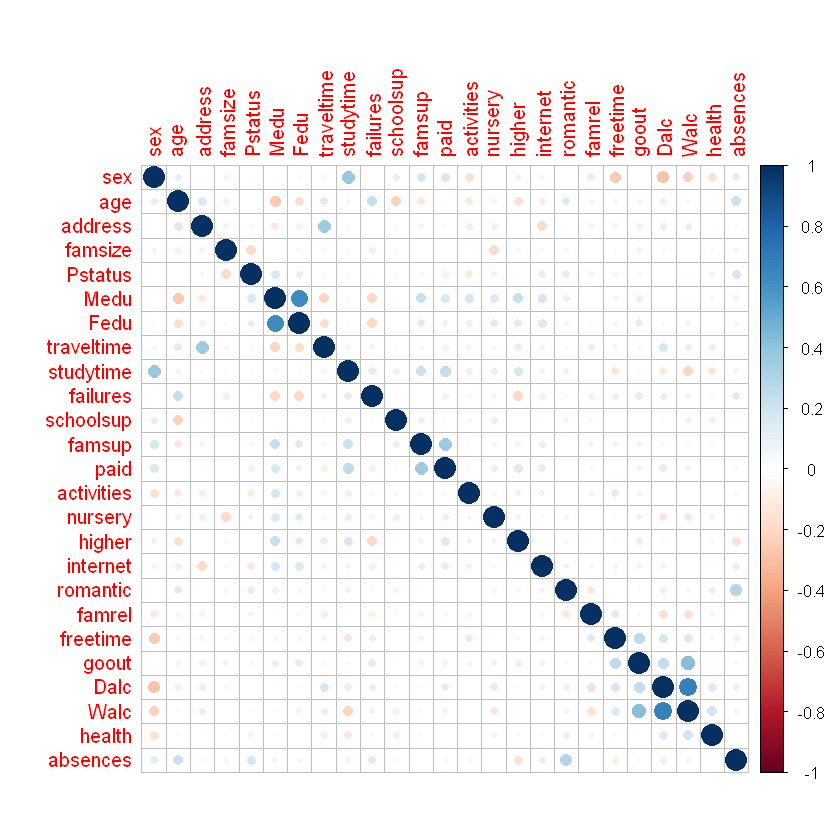

In [2]:
########################  Correlation analysis  ########################
cor <- round(cor(train[,c(1:25)]),2) # Variable 26 is the depedendent variable
corrplot(cor)

The covariates do not correlate highly with each other. There are only two pairs of variables with a correlation coefficient above 0.5:
- *Fedu*, *Medu* ($corr = 0.62$),
- *Walc*, *Dalc* ($corr = 0.67$).

**b) Regress the final grade on all the covariates using the training sample. Compute the MSE in the test sample.
Why do we calculate the MSE in the test data and not in the training data? Does the coeficient *schoolsup* have the expected sign? Which sign would you expect in a causal model? Does this imply that our prediction model is misspecified?**

In [3]:
########################  Estimation of the linear regression  ########################

ols <- lm(G3 ~ ., data = train)
summary(ols)

# Calculate the MSE
test$predols <- predict(ols, newdata = test)

predMSEols <- mean((test$G3 - test$predols)^2)
print(predMSEols)

########################################################################################


Call:
lm(formula = G3 ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.5524 -1.9313  0.1568  1.8190  8.5320 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14.62145    3.68541   3.967 0.000103 ***
sex         -0.62733    0.49221  -1.275 0.204052    
age         -0.16293    0.19173  -0.850 0.396517    
address     -0.42789    0.53423  -0.801 0.424171    
famsize     -0.47520    0.46329  -1.026 0.306346    
Pstatus      0.26090    0.63117   0.413 0.679816    
Medu         0.34875    0.25380   1.374 0.171046    
Fedu         0.09652    0.23729   0.407 0.684661    
traveltime   0.22792    0.32065   0.711 0.478090    
studytime    0.68759    0.27570   2.494 0.013496 *  
failures    -0.69699    0.32437  -2.149 0.032934 *  
schoolsup   -3.47010    0.67917  -5.109 7.91e-07 ***
famsup      -0.76877    0.46120  -1.667 0.097202 .  
paid        -0.39143    0.44383  -0.882 0.378945    
activities   0.22703    0.42261   0.537 0.591760    
n

[1] 9.300887


<ins> MSE on the training vs test set: <ins>

The test sample MSE is 

$ MSE=\frac{1}{n_{test}} \sum_{i=1}^{n_{test}} {(y_i - \hat{y}_i)}^2 = 9.30,$

where $y_i$ is the actual final grade (*G3*) and $\hat{y}_i$ is the predicted final grade (*predols*). To estimate $\hat{y}_i$ in the test sample, we multiply the characteristics $x$ from the test sample with the coefficients $\hat{\beta}$ which we estimated in the training sample.

  
Calculating the MSE error on the training set, i.e. in-sample, would yield a far too optimistic estimate of the prediction error. OLS minimizes the sum of squared residuals, $\sum_{i=1}^{n_{train}} {(y_i - \hat{y}_i)}^2$, in the training sample. As a consequence, training error is a poor generalization of the out-of-sample performance. Training and testing the model in different independent samples avoids a systematically too optimistic evaluation of the model. This is called the "firewall" principle.
    
<ins> Interpretation of the coefficients: <ins>

The coefficient schoolsup has a negative coefficient. This is justifiable in a predictive model as the students who have difficulties with math are more likely to participate in
extra educational study support. The predictive model exploits the fact that students with worse grades are to be found in extra educational study support groups.

In a causal analysis, this is called a selection bias as the less successful students are selected into such activities driving the sign of the coefficient. In a causal model,
extra educational study support is on the contrary expected to improve the final
grade, i.e. schoolsup should have a positive sign. In order to identify the causal efect
of extra educational study support, one would for example need experimental data or
a valid instrumental variable. 

There is no notion of a misspeciffied predictive model. A predictive model looks for a formula which gives the best predictions based on any combination of the available
variables. Even if the coefficients are biased, the predictive model might still yield
better predictions than a model with unbiased coefficients. However, we should not overinterpret the coefficients of a predictive model
    
In a causal analysis, misspecification is an important issue as one gets biased and inconsistent estimates of
the coefficients when the model is misspecified leading to incorrect conclusions of the effect of x on y.


**c) Try to find an OLS model which uses fewer covariates and has a lower MSE in the
test sample.**

In [4]:
########################  OLS model  ########################

ols_small <- lm(G3 ~ failures , data = train)

# Calculate the MSE
test$predols_small <- predict(ols_small, newdata = test)

predMSEols_small <- mean((test$G3 - test$predols_small)^2)
print(predMSEols_small)

[1] 9.173886


For example, the simple model

$G3 = \beta_0 + \beta_1 failures + U$
            
yields  a lower MSE than the full model ($MSE = 9.17 < 9.30$). We face a bias-variance trade-off. Too parsimonious models have a large bias and a small variance. Too flexible model have a small bias but a large out-of-sample variance. We can search manually for a model that balances the bias-variance trade-off. However, such as unsystematic search is exhausting. With 25 covariates, we have around 33.5 million different models. For a more systematic search, one could use Lasso to select most relevant variables.

# Exercise 2 : Lasso and Ridge

The Lasso minimizes the sum of squared residuals, subject to a penalty on the absolute size of the coefficients $\beta_j$. The Lasso objective function is

\begin{equation*}
\min_{\beta} \left\{ \sum_{i=1}^{N} \left( Y_i-  \gamma -\sum_{j=1}^{p}X_{ij}\beta_j \right)^2 + \lambda \sum_{j=1}^{p} | \beta_j| \right\},
\end{equation*}
with $p$ being the total number of control variables.

The penalty term $\lambda \geq 0$ enables to regulate the degree of penalization. When $\lambda=0$, there is no penalization and the Lasso and OLS estimates are similar. When $\lambda>0$, some coefficients are shrunken towards zero and eventually approach zero excatly. When $\lambda$ is very large, all coefficients are zero, excluding the constant $\gamma$. The constant term is not penalized. When the coefficient $\beta_j$ is zero, this is equivalent to omit the corresponding characterstic $X_j$ from the model. Accordingly, the Lasso is a model selection device. 

The Ridge minimizes the sum of squared residuals, subject to a penalty on the squared coefficients $\beta_j$. The Ridge objective function is

\begin{equation*}
\min_{\beta} \left\{ \sum_{i=1}^{N} \left( Y_i-  \gamma -\sum_{j=1}^{p}X_{ij}\beta_j \right)^2 + \lambda \sum_{j=1}^{p}  \beta_j^2 \right\}.
\end{equation*}

Similar to the Lasso, larger values of $\lambda$ imply more penalization. However, the coefficients are not exactly zero, unless the penalty is so large that all coefficients are jointly zero. Accordingly, Ridge cannot be used for model selection. Lasso is more suited when the true underlying model is sparse and Ridge is more suited when the true underling model is dense.
 
An important tuning parameter is the penalty term $\lambda$. We can use a cross-validation procedure the specify the optimal penalty term. We partition the sample into $k$ equally large folds and specify a grit of possible $\lambda$ values (typically equispaced on a log-scale). We estimate the Lasso for a specific $\lambda$ value in $k-1$ folds and extrapolate the fitted values to the retained fold. Then we calculate the model quality in the retained fold (e.g. using the MSE). We repeat this procedure k-times while alternating the retained fold. We calculate the average model quality across all folds. Then we repeat this procedure for all $\lambda$ values on the grit. Finally, we select the $\lambda$ value with the best average model quality (or we apply the one-standard-error-rule). 

Note that all control variables are standardized before the estimation, such that the scaling of the variables has no impact on the results.

**a) Estimate the linear regression model as before with the lasso penalty. Choose the optimal $\lambda$ by a 5-fold cross validation. Compute the MSE in the test sample.**

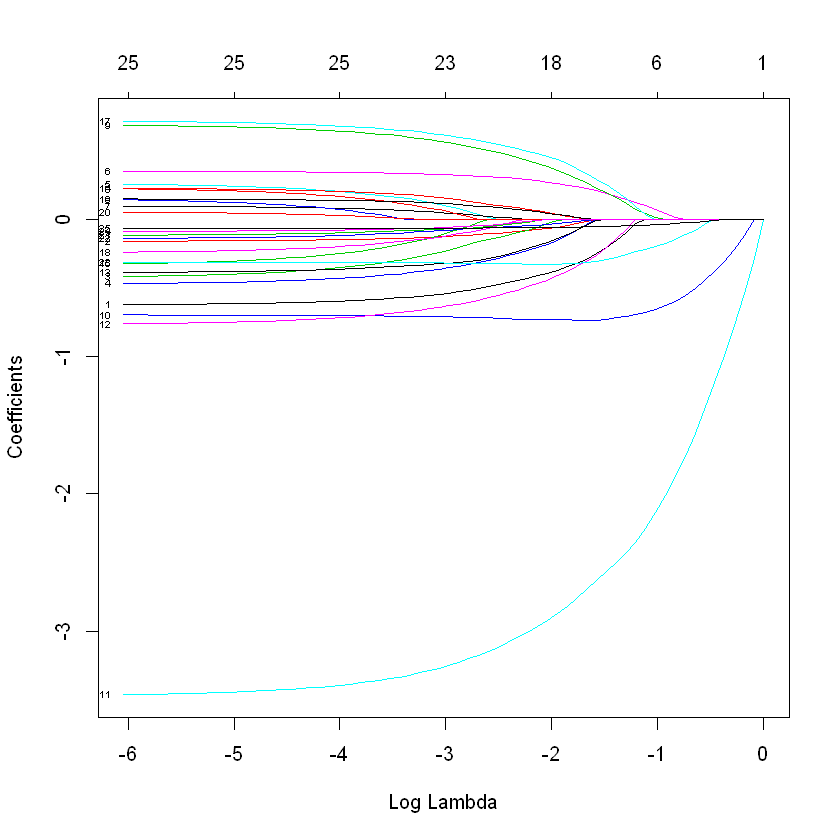

In [5]:
########################  Lasso Path  ########################

# We make a plot that shows how the Lasso coefficients change with lambda
# glmnet is the standard R package for Lasso, Ridge, and Elastic Net
# alpha is a parmeter that allows to specify a Lasso, Ridge, or Elastic Net model
# alpha = 1 for Lasso; alpha = 0 for Ridge, 0 < alpha < 1 for Elastic Net
# The control variables are train[,c(1:25)]
# The outcome variable is train$G3 (math grades)

# Estimate a Lasso model
lasso <- glmnet(as.matrix(train[,c(1:25)]), train$G3, alpha = 1) # We save the model under the name "lasso"
plot(lasso, xvar = "lambda", label = TRUE)

###############################################################

The lower x-axis shows the $log(\lambda)$ values. The upper x-axis shows the number of control variables with non-zero coefficients. The small numbers to the left of the colored lines are the variables sequence numbers. For example variable 11 is *schoolsup*, the eleventh variables in $train$.

The model complexity varies from complex (left) to sparse (right). The Lasso model is equal to the OLS model on the extrem left. The Lasso model contains only a constant on the extrem right.

We plotted now the Lasso model for different $\lambda$ values, but we do not know the optimal $\lambda$ value. We use now a cross-validation procedure to estimate the optimal $\lambda$ value.

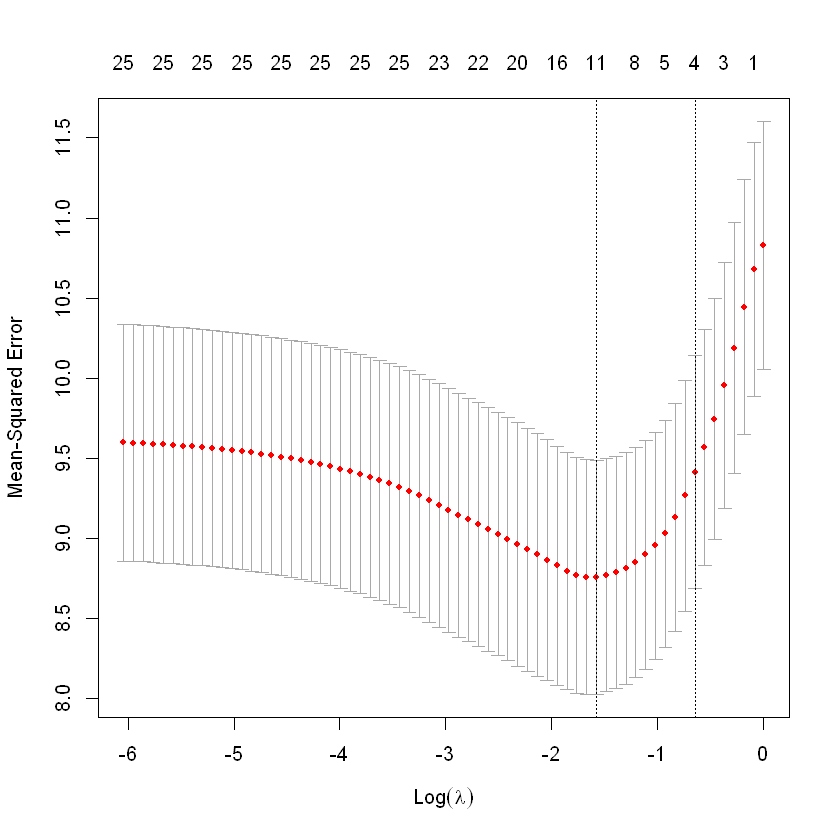

In [6]:
########################  Cross-Validaton  ########################

# Set starting value for replicability
set.seed(27112019) 

# cv.glmnet performs a cross-validation to determine the optimal lambda value
# type.measure specifies the measure we use to assess the model accuracy (here MSE)
# nfolds specifies the number of cross-validation folds we use (here 5)

# Cross-validate the Lasso
lasso.cv <- cv.glmnet(as.matrix(train[,c(1:25)]), train$G3, type.measure = "mse", nfolds = 5, alpha = 1)

# Plot the MSE for the different lambda values
plot(lasso.cv)

#####################################################################

In the plot we see the bia-variance trade-off. On the right wer have a sparse model with a large bias and a small variance. On the left we have a complex model with a small bias and large variance. The optimal $\lambda$ value balances the bias and variance. We can either use the $\lambda$ value which minimizes the cross-validated MSE or we can apply the one-standard-error-rule to the $\lambda$.

In [7]:
########################  Optimal Lambda Value  ########################

# Print the optimal lambda value
print(paste0("Optimal lambda that minimizes cross-validated MSE: ", lasso.cv$lambda.min))
print(paste0("Optimal lambda using one-standard-error-rule: ", lasso.cv$lambda.1se))

#########################################################################

[1] "Optimal lambda that minimizes cross-validated MSE: 0.207030691346121"
[1] "Optimal lambda using one-standard-error-rule: 0.524898263546244"


Lets use the $\lambda$ value which minimizes the cross-validated MSE. Now we can plot the Lasso coefficients of the corresponding model.

In [8]:
########################  Lasso Coefficients  ########################

# Print Lasso coefficients
print(coef(lasso.cv, s = "lambda.min"))

# Save for later comparison
coef_lasso1 <- coef(lasso.cv, s = "lambda.min") 

#######################################################################

26 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept) 12.250119356
sex         -0.253655763
age         -0.005993140
address      .          
famsize      .          
Pstatus      .          
Medu         0.205313808
Fedu         .          
traveltime   .          
studytime    0.225203555
failures    -0.735333357
schoolsup   -2.630320953
famsup      -0.264083468
paid        -0.007662321
activities   .          
nursery      .          
higher       .          
internet     0.290229576
romantic     .          
famrel       .          
freetime     .          
goout        .          
Dalc         .          
Walc        -0.310153714
health       .          
absences    -0.055696698


Missing coefficients have a value of zero. The corresponding control variables are excluded from the Lasso model.

Next, we calculate the MSE in the test sample. We use the test sample MSE to compare different estimators.

In [9]:
########################  Test Sample MSE  ########################

# Estimate the fitted values of the Lasso model in the test sample
# We use the model "lasso.cv" and the lambda value which we estimated in the training sample
# The control variables "newx" are from the test sample

# Fitted values
test$predlasso <- predict(lasso.cv, newx = as.matrix(test[,c(1:25)]), s = lasso.cv$lambda.min)

# Calculate the MSE
predMSElasso <- mean((test$G3 - test$predlasso)^2)
print(paste0("MSE: ", predMSElasso))
      
#####################################################################

[1] "MSE: 8.86020510329204"


**b) Estimate the lasso model with different seeds for the cross validation. Do the models always select the same regressors? What are the potential reasons?**

In [10]:
########################  Different Starting Value  ########################

# Change the starting value
set.seed(27112025) # 27112024

# Re-estimate the Lasso model
lasso.cv <- cv.glmnet(as.matrix(train[,c(1:25)]), train$G3, type.measure = "mse", nfolds = 5, alpha = 1)

# Store the coefficients
coef_lasso2 <- coef(lasso.cv, s = "lambda.min")
print(cbind(coef_lasso1, coef_lasso2))

# Calculate the fitted values
test$predlasso2 <- predict(lasso.cv, newx = as.matrix(test[,c(1:25)]), s = lasso.cv$lambda.min)

# Correlation between the fitted values of the two Lasso models
cor_fit <- cor(test$predlasso,test$predlasso2)
print(paste0("Correlation between fitted values: ", cor_fit))

26 x 2 sparse Matrix of class "dgCMatrix"
                       1           1
(Intercept) 12.250119356 13.04711783
sex         -0.253655763 -0.37142548
age         -0.005993140 -0.05905128
address      .           -0.01402183
famsize      .           -0.15327144
Pstatus      .            .         
Medu         0.205313808  0.25785159
Fedu         .            .         
traveltime   .            .         
studytime    0.225203555  0.35493497
failures    -0.735333357 -0.73379513
schoolsup   -2.630320953 -2.87055940
famsup      -0.264083468 -0.41404381
paid        -0.007662321 -0.14260444
activities   .            0.03395797
nursery      .            .         
higher       .            .         
internet     0.290229576  0.43063807
romantic     .            .         
famrel       .            0.03407563
freetime     .            .         
goout        .            .         
Dalc         .           -0.03239379
Walc        -0.310153714 -0.33105107
health       .            .      

The two Lasso models select very different variables and differ greatly from each other. However, the fitted values of both models are highly correlated ($corr = 0.99$). Accordingly, the prediction performance is almost identical.


Potential reasons for diffirent covariates chosen:
- Lasso is a conservative model selection method, i.e. it selects too many covariates, including some covariates which are not very important. This might be the case for *famrel* coefficient with a close to zero coefficient in the second seed. We can select a more parimonious model by using the $\lambda$ of the one-standard-error-rule.
- Lasso has difficulties to deal with highly correlated covariates as they carry similar information for the prediction. In case of extremely high correlations, Lasso will randomly pick one of the highly correlated covariates to represent the group in the model. This might be the case of *Dalc* and *Walc*. In case, both of them are in the true model, it is challenging for Lasso to recover the true model because of the high correlation.

**c) Estimate the linear regression model as before with the ridge penalty. Choose the
optimal $\lambda$ by a 5-fold cross validation. Compute the MSE in the test sample.**

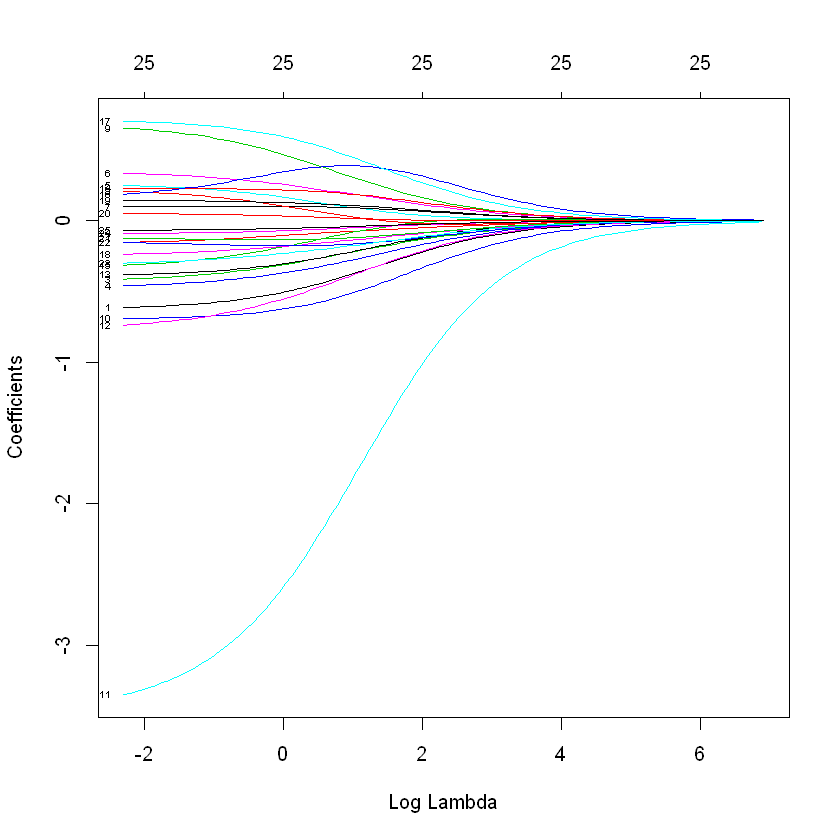

In [11]:
########################  Ridge Path  ########################

# alpha = 0 specifies a Ridge model

# Estimate the Ridge
ridge <- glmnet(as.matrix(train[,c(1:25)]), train$G3, alpha = 0)

# Plot the path of the Ridge coefficients
plot(ridge, xvar = "lambda", label = TRUE)

###############################################################

The penalization of the coefficients increases from the left to right side of the plot. The coefficients are shrunken towards zero, but they approach exactly zero only on the extrem right. For very large $\lambda$ values all coefficients are jointly zero.

Next, we select the optimal $\lambda$ value using a cross-validation procedure.

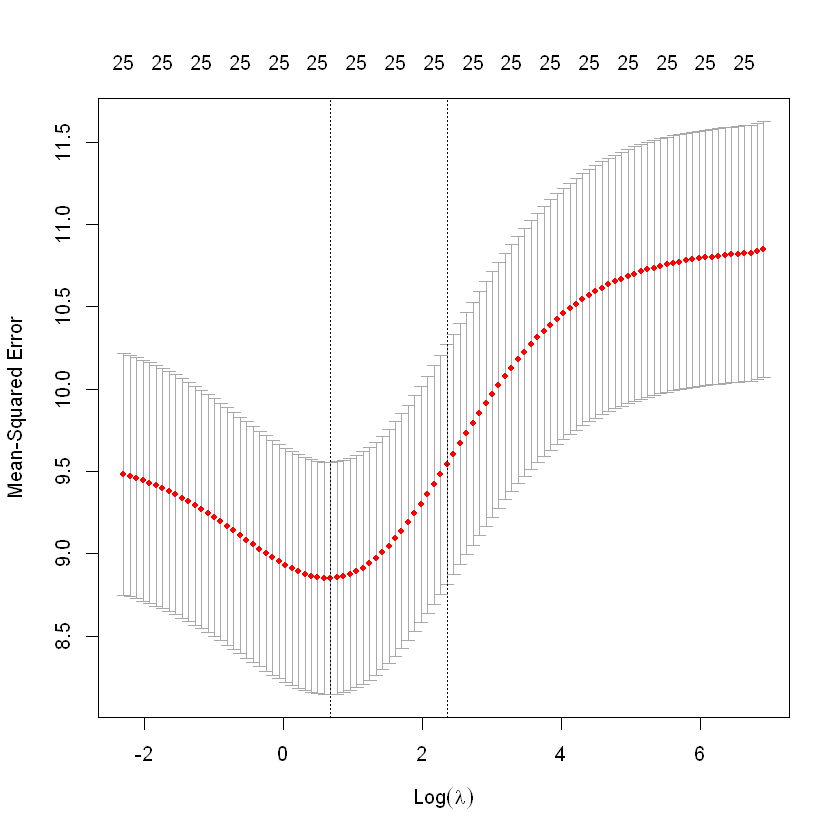

In [12]:
########################  Cross-Validation  ########################

# Set starting value
set.seed(27112019)

# Cross-validate the Ridge model 
ridge.cv <- cv.glmnet(as.matrix(train[,c(1:25)]), train$G3, type.measure = "mse", nfolds = 5, alpha = 0)

# Plot the MSE in the cross-validation samples
plot(ridge.cv)

#####################################################################

In the plot, we see the bias variance trade-off for the Ridge. The optimal $\lambda$ value is:

In [13]:
########################  Optimal Lambda Value  ########################

# Print the optimal lambda value
print(paste0("Optimal lambda that minimizes cross-validated MSE: ", ridge.cv$lambda.min))
print(paste0("Optimal lambda using one-standard-error-rule: ", ridge.cv$lambda.1se))

#########################################################################

[1] "Optimal lambda that minimizes cross-validated MSE: 1.97620827762209"
[1] "Optimal lambda using one-standard-error-rule: 10.5464291794412"


We select the $\lambda$ that minimizes the MSE and plot the Ridge coefficients.

In [14]:
########################  Ridge Coefficients  ########################

# Print Ridge coefficients
print(coef(ridge.cv, s = "lambda.min"))

# Save for later comparison
coef_ridge <- coef(ridge.cv, s = "lambda.min") 

#######################################################################

26 x 1 sparse Matrix of class "dgCMatrix"
                      1
(Intercept) 12.94080662
sex         -0.42225544
age         -0.08314731
address     -0.24984549
famsize     -0.30876169
Pstatus      0.11796154
Medu         0.21089603
Fedu         0.09683688
traveltime   0.04969724
studytime    0.36062997
failures    -0.55560665
schoolsup   -2.08642928
famsup      -0.44044860
paid        -0.24836700
activities   0.20087023
nursery     -0.11340779
higher       0.38613173
internet     0.50139834
romantic    -0.15049638
famrel       0.11637309
freetime     0.02250704
goout       -0.12642101
Dalc        -0.17216585
Walc        -0.19404329
health      -0.05676600
absences    -0.04516606


In contrast to the Lasso model, the Ridge model keeps all control variables. Accordingly, Ridge is suited for dense models. In coparison to OLS, the Ridge coefficients are shrunken towards zero.

Finally, we estimate the test sample MSE for the Ridge.

In [15]:
########################  Test Sample MSE  ########################

# Estimate fitted values in test sample
test$predridge <- predict(ridge, newx = as.matrix(test[,c(1:25)]), s = ridge.cv$lambda.min)

# Calculate the MSE
predMSEridge <- mean((test$G3 - test$predridge)^2)
print(paste0("MSE: ", predMSEridge))

###################################################################

[1] "MSE: 8.31374219953683"


**d) Compare the Lasso and Ridge coefficients for the pair of variables with the highest
correlation.**

The variables with the highest correlations are *Dalc* and *Walc*.

In [16]:
########################  Compare Lasso and Ridge Coefficients  ########################

# Pick the coefficients of Dalc and Walc
comp <- cbind(coef(ols)[23:24], coef_lasso1[23:24], coef_lasso2[23:24], coef_ridge[23:24]) 
colnames(comp) <- c("OLS", "Lasso1", "Lasso2", "Ridge")
print(comp)

#########################################################################################

            OLS     Lasso1      Lasso2      Ridge
Dalc -0.1445464  0.0000000 -0.03239379 -0.1721658
Walc -0.3126125 -0.3101537 -0.33105107 -0.1940433


The Lasso tends to give preference to one of the highly correlated variables and shrink the other towards zero. The Ridge tends to give evenly sized coefficients to highly correlated variables. 

**e) Compare the MSE of all the three methods (OLS, Lasso and Ridge). Which one yields the best predictive model?**

In [17]:
########################  Compare the MSE  ########################

# Print the MSE of the OLS, Lasso and Ridge models
print(c(predMSEols, predMSElasso, predMSEridge))

####################################################################

[1] 9.300887 8.860205 8.313742


Lasso and Ridge both outperform the OLS model in the test sample. Accordingly, penalized regressions can improve the prediction power compared to OLS.

In this application, the Ridge outperforms the Lasso regression. This result is specific to the current application. In other applications the Lasso might outperform the Ridge.

To further improve the model, one could try Elastic Net which combines Lasso and Ridge penalties.

**f) Plot the predicted grades (by OLS, lasso and ridge) against the actual grades and
compare the methods.**

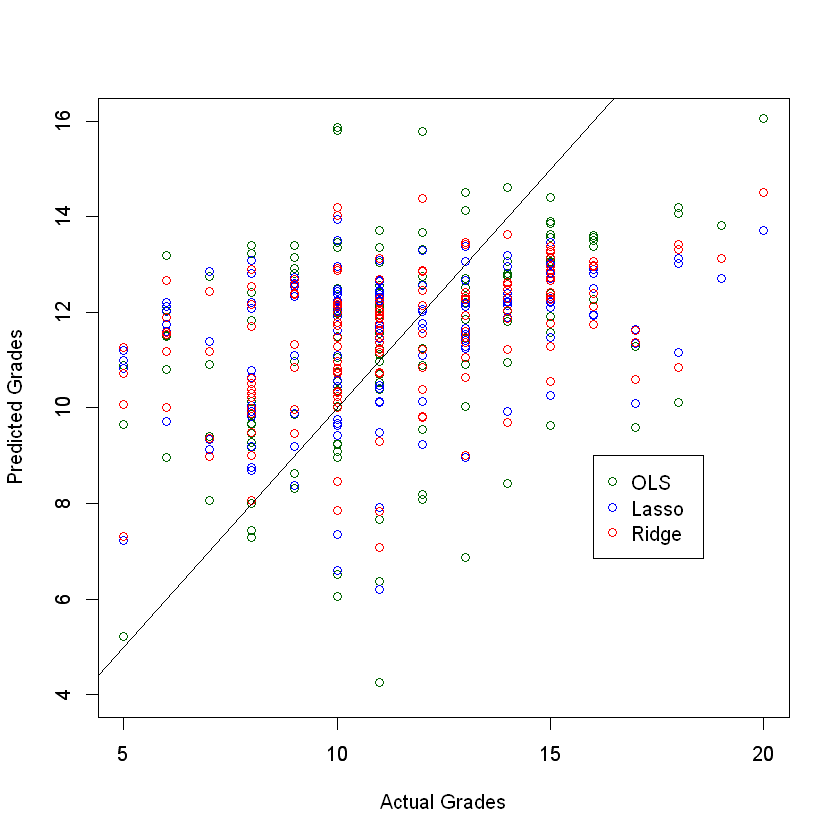

In [18]:
########################  Compare models  ########################

# Visualize the predictions (Predicted vs Actual)
plot(test$G3,test$predols,xlim=c(5,20),ylim=c(4,16), col= "darkgreen", xlab = "Actual Grades", ylab = "Predicted Grades" )
par(new=TRUE)
plot(test$G3,test$predlasso,xlim=c(5,20),ylim=c(4,16), col= "blue", xlab = "", ylab = "" )
par(new=TRUE)
plot(test$G3,test$predridge,xlim=c(5,20),ylim=c(4,16), col= "red", xlab = "", ylab = "" )
abline(a=0,b=1)
legend(16, 9, c("OLS", "Lasso", "Ridge"), col = c("darkgreen", "blue", "red"), pch = c(21, 21, 21))

####################################################################

In the idel case, the predicted and actual grades would be similar (45 degree line). The figure shows that Lasso and Ridge improve the prediction in many cases, especially for students whose grades are highly overestimated or underestimated in the lower and middle range of the grades. This can be seen from a smaller distance of the blue and red points to the 45 degree line. For high performing students the Lasso and Ridge tend to underestimate the grades more than OLS.